## 1. Descripción del dataset

El dataset a tratar en la práctica es  https://www.kaggle.com/datasets/rashikrahmanpritom/heart-attack-analysis-prediction-dataset.

Se trata de un dataset con 14 variables, las cuales estan asociadas a pancientes con síntomas coronarios y cuyo objetivo es la predicción de la probabilidad (mayor o menor) de tener un ataque al corazón bajo esos síntomas. El dataset es de mucha relevancia, dado que poder entrerar un modelo que anticipe esta circunstancia podría ayudar a salvar muchas vidas. 

El dataset consta de las siguientes variables:
- **age** : Edad del paciente
- **sex**: Sexo del paciente, 1: Hombre, 2: Mujer
- **cp** : Chest Pain type chest pain type. Tipo de dolor en el pecho. Puede tomar los valores:
    - Valor 0: typical angina
    - Valor 1: atypical angina
    - Valor 2: non-anginal pain
    - Valor 3: asymptomatic
     
    > Aunque en el dataset de referenca de Kaggle de indica que el rango de valores de la variable es [1..4],  analizando el fichero se observa que es [0..3]
    
- **trtbps** : resting blood pressure (in mm Hg). Presion sanguinea en reposo.
- **chol** : cholestoral in mg/dl fetched via BMI sensor. Colesterol en sangre.
- **fbs** : (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false). Azugar en sangre en ayunas por encima de 129 mg/dl. Codificado como 1 Verdadero, 0 Falso.
- **restecg** : resting electrocardiographic results. Resultados del electrocardiograma en reposo. Puede tomar los siguientes valores:
    - Valor 0: normal
    - Valor 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    - Valor 2: showing probable or definite left ventricular hypertrophy by Estes' criteria.

- **thalachh** : maximum heart rate achieved. Frecuencia cardiaca máxima.
- **exng**:  "exercise induced angina". Angina inducida por el ejercicio. Codificado como 1 "Si" 0 "No".
- **caa**: number of major vessels. Numero de vasos sanguineos mayores. Codificado de 0 a 4. 

    > En la descripción del dataset de Kaggle se indica que que el rango de la variable es 0..3, sin embargo observando el fichero, se codifica de 0..4. Esto es mas coherente, ya que los vasos mayores del corazón son 5.
    
- **output** :  Variable objetivo. 0 = menor posibilidad de ataque al corazón 1 = mayor posibilidad de ataque al corazon.

El dataset consta de otras tres variables que no están descritas y no conocemos su significado (oldpeak, slp y thall) que no utilizaremos por pruedencia.

A continuación, vamos a visualizar los primeros datos del dataset

In [846]:
import warnings
import pandas as pd
from matplotlib import pyplot as plt, colors

warnings.filterwarnings('ignore')

raw_data = pd.read_csv("./datos/heart.csv")
df = raw_data.copy()
df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


## 2. Integración y selección

El dataset contiene toda la información necesaria por sí mismo, sin necesidad de integrarlo con otras fuentes.

Sin embargo, vamos a integrarlo con ficheros que contienen las descripciones de los campos categoricos del dataset, de manera que sea más fácil su interpretación y trabajo con los datos.

Después de la integración de cada fichero, borraremos la columna de cruce del fichero integrado, para no duplicar la columna.

#### Exang

In [847]:
df_exang = pd.read_csv("./datos/exang.csv")

In [848]:
df = df.merge(df_exang, how="left", left_on="exng", right_on="id_exang").drop(["id_exang"], axis=1)

#### Chest pain

In [849]:
df_cp = pd.read_csv("./datos/chest_pain.csv")

In [850]:
df = df.merge(df_cp, left_on="cp", right_on="id_cp", how="left").drop(["id_cp"], axis=1)

#### Fasting Blood Sugar

In [851]:
df.loc[df.fbs == 1, 'desc_fbs'] = 'Fasting Blood Sugar > 120 mg/dl'
df.loc[df.fbs == 0, 'desc_fbs'] = 'Fasting Blood Sugar < 120 mg/dl'

#### Sex

In [852]:
df.loc[df.sex == 1, 'desc_sex'] = 'Man'
df.loc[df.sex == 0, 'desc_sex'] = 'Woman'

#### ResteCG


In [853]:
df.loc[df.restecg == 2, 'desc_restecg'] = 'Left Ventricular atrophy'
df.loc[df.restecg == 1, 'desc_restecg'] = 'ST-T Wave abnormality'
df.loc[df.restecg == 0, 'desc_restecg'] = 'Normal'

#### Output

In [854]:
df.loc[df.output == 1, 'desc_output'] = 'High heart attack risk'
df.loc[df.output == 0, 'desc_output'] = 'Low heart attack risk'

Borramos las columnas que no vamos a utilizar:

In [855]:
df = df.drop(["oldpeak", "slp", "thall"], axis=1)

Visualizamos el dataset final una vez generadas todas las descripciones para columnas categóricas.

## 3. Limpieza de los datos.

### - Valores nulos

Obenemos un listado de las columnas que tienen nulos y el porcentaje que representan sobre el total de datos.

In [856]:
df.apply(lambda x: sum(x.isnull())/len(x))

age             0.0
sex             0.0
cp              0.0
trtbps          0.0
chol            0.0
fbs             0.0
restecg         0.0
thalachh        0.0
exng            0.0
caa             0.0
output          0.0
desc_exang      0.0
desc_cp         0.0
desc_fbs        0.0
desc_sex        0.0
desc_restecg    0.0
desc_output     0.0
dtype: float64

Como vemos, no existen valores nulos que representen pérdida de información.

### - Valores extremos

En el análisis de valores extremos nos fijaremos en las siguientes variables, ya que son las que tienen dominios contínuos y para las que tiene sentido realizar este análisis.

In [857]:
features = ["trtbps","chol","age","thalachh"]

#### Análisis univariante

Para detectar los outliers univariantes, realizamos un box plot y buscamos puntos identificados como atípicos. Dado que no disponemos de muchos datos, en vez de eliminarlos, una vez identificados los marcaremos como Null e imputaremos utilizando kNN. De esta manera podremos obtener distribuciones más normales para los análisis posteriores del apartado 5.

**Identificación de valores extremos**

<AxesSubplot: >

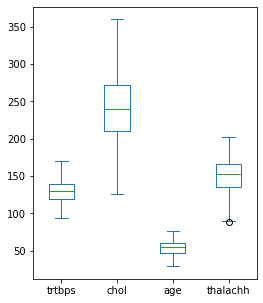

In [885]:
df[features].plot.box(figsize=(4,5))

Imprimimos los valores atípicos:

In [859]:
from matplotlib.cbook import boxplot_stats

stats_boxplot = list(zip(features, boxplot_stats(df[features])))

_ = [print(feature, stats["fliers"]) for feature, stats in stats_boxplot]

trtbps [172 178 180 180 200 174 192 178 180]
chol [417 564 394 407 409]
age []
thalachh [71]


**Eliminación de valores extremos**

In [860]:
for feature, stats in stats_boxplot:
    for stat in stats["fliers"]:
        df[feature].replace({stat: None}, inplace=True)

**Imputación de valores extremos**

In [861]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)
df[features] = imputer.fit_transform(df[features])

df[features] = pd.DataFrame(df, columns=df[features].columns)
df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,caa,output,desc_exang,desc_cp,desc_fbs,desc_sex,desc_restecg,desc_output
0,63.0,1,3,145.0,233.0,1,0,150.0,0,0,1,no,asymptomatic,Fasting Blood Sugar > 120 mg/dl,Man,Normal,High heart attack risk
1,37.0,1,2,130.0,250.0,0,1,187.0,0,0,1,no,non-anginal pain,Fasting Blood Sugar < 120 mg/dl,Man,ST-T Wave abnormality,High heart attack risk
2,41.0,0,1,130.0,204.0,0,0,172.0,0,0,1,no,atypical angina,Fasting Blood Sugar < 120 mg/dl,Woman,Normal,High heart attack risk
3,56.0,1,1,120.0,236.0,0,1,178.0,0,0,1,no,atypical angina,Fasting Blood Sugar < 120 mg/dl,Man,ST-T Wave abnormality,High heart attack risk
4,57.0,0,0,120.0,354.0,0,1,163.0,1,0,1,yes,typical angina,Fasting Blood Sugar < 120 mg/dl,Woman,ST-T Wave abnormality,High heart attack risk


Ahora podemos comprobar mediante un Box Plot que ya no obtenemos valores extremos mediante análisis univariante.

<AxesSubplot: >

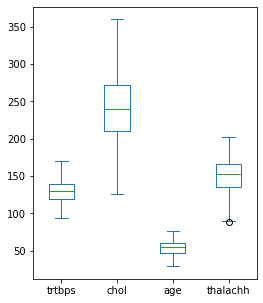

In [886]:
df[features].plot.box(figsize=(4,5))

#### Análisis multivariante

El siguiente paso será verificar si existen valores extremos mediante análisis multivariante. Esto nos permitirá identificar los puntos que se encuentran muy alejados del conjunto global de los datos y realizar un tratamiento sobre ellos si se requiere.

Para identificar los valores extremos, realizaremos una clusterización utilizando OPTICS. El primer paso para ello será escalar los datos, utilizaremos MinMax.

In [863]:
from sklearn.preprocessing import MinMaxScaler

scaled = MinMaxScaler().fit_transform(df[features])

df_scaled = pd.DataFrame(scaled, columns=features)

Number of clusters:  9


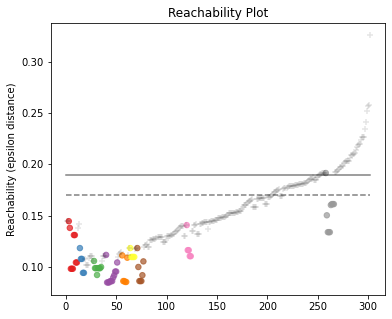

In [887]:
import numpy as np

from sklearn.cluster import OPTICS, cluster_optics_dbscan

cut_line_1 = .17# .19
cut_line_2 = .19# .22

clust= OPTICS().fit(df_scaled)

space = np.arange(len(df_scaled))
reachability = clust.reachability_[clust.ordering_]
labels = clust.labels_[clust.ordering_]

# Normalización de las etiquetas para obtener los colores de los clusters
norm = colors.Normalize(vmin=0, vmax=max(labels))

plt.figure(figsize=(6, 5))

# Plot datos normales
plt.scatter(space[labels!=-1], reachability[labels!=-1], c=labels[labels!=-1], norm=norm, s=30, cmap="Set1", alpha=.7)
# Plot atipicos
plt.scatter(space[labels==-1], reachability[labels==-1], c="black", s=30, alpha=.1, marker="+")

# Lineas de corte de extracción eps
plt.plot(space, np.full_like(space, cut_line_1, dtype=float), "k--", alpha=0.5)
plt.plot(space, np.full_like(space, cut_line_2, dtype=float), "k-", alpha=0.5)

plt.ylabel("Reachability (epsilon distance)")
plt.title("Reachability Plot")

print("Number of clusters: ",labels.max()+1)

Situamos dos lineas de corte para la extracción de los clusters. Una por encima del último cluster en la que la pendiente de los atipicos se vuelve más empinada (donde sólo analizaremos los datos atípicos mas solitarios) y otra justo por debajo del último cluster, para poder comparar los atípicos que extraemos asumiendo que el último cluster es ya extraño.

In [865]:
def extract_cluster_dbscan_eps(eps):
    labels = cluster_optics_dbscan(
        reachability=clust.reachability_,
        core_distances=clust.core_distances_,
        ordering=clust.ordering_,
        eps=eps
    )
        
    return labels

In [866]:
labels_1 = extract_cluster_dbscan_eps(cut_line_1)
labels_2 = extract_cluster_dbscan_eps(cut_line_2)

df["atipico_1"] = labels_1 == -1
df["atipico_2"] = labels_2 == -1

print("Number of clusters atipico_1: ",labels_1.max() + 1)
print("Number of clusters atipico_2: ",labels_2.max() + 1)

Number of clusters atipico_1:  3
Number of clusters atipico_2:  2


A continuación, visualizamos los registros que se están identificando como outliers:

In [867]:
df.loc[df.atipico_2 == True].head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,caa,output,desc_exang,desc_cp,desc_fbs,desc_sex,desc_restecg,desc_output,atipico_1,atipico_2
25,71.0,0,1,160.0,302.0,0,1,162.0,0,2,1,no,atypical angina,Fasting Blood Sugar < 120 mg/dl,Woman,ST-T Wave abnormality,High heart attack risk,True,True
39,65.0,0,2,160.0,360.0,0,0,151.0,0,0,1,no,non-anginal pain,Fasting Blood Sugar < 120 mg/dl,Woman,Normal,High heart attack risk,True,True
44,39.0,1,2,140.0,321.0,0,0,182.0,0,0,1,no,non-anginal pain,Fasting Blood Sugar < 120 mg/dl,Man,Normal,High heart attack risk,True,True
53,44.0,0,2,108.0,141.0,0,1,175.0,0,0,1,no,non-anginal pain,Fasting Blood Sugar < 120 mg/dl,Woman,ST-T Wave abnormality,High heart attack risk,True,True
60,71.0,0,2,110.0,265.0,1,0,130.0,0,1,1,no,non-anginal pain,Fasting Blood Sugar > 120 mg/dl,Woman,Normal,High heart attack risk,True,True


Vamos a eliminar estos registros para que no desvirtúen los análisis estadísticos posteriores. A partir de este punto ya no realizaremos más modificaciones sobre los datos, pásamos a utilizar la variable data.

In [868]:
data = df.loc[df.atipico_2 == False]
data = data.drop(columns = ["atipico_1", "atipico_2"])

In [869]:
data = df.copy()
data.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,caa,output,desc_exang,desc_cp,desc_fbs,desc_sex,desc_restecg,desc_output,atipico_1,atipico_2
0,63.0,1,3,145.0,233.0,1,0,150.0,0,0,1,no,asymptomatic,Fasting Blood Sugar > 120 mg/dl,Man,Normal,High heart attack risk,False,False
1,37.0,1,2,130.0,250.0,0,1,187.0,0,0,1,no,non-anginal pain,Fasting Blood Sugar < 120 mg/dl,Man,ST-T Wave abnormality,High heart attack risk,False,False
2,41.0,0,1,130.0,204.0,0,0,172.0,0,0,1,no,atypical angina,Fasting Blood Sugar < 120 mg/dl,Woman,Normal,High heart attack risk,False,False
3,56.0,1,1,120.0,236.0,0,1,178.0,0,0,1,no,atypical angina,Fasting Blood Sugar < 120 mg/dl,Man,ST-T Wave abnormality,High heart attack risk,False,False
4,57.0,0,0,120.0,354.0,0,1,163.0,1,0,1,yes,typical angina,Fasting Blood Sugar < 120 mg/dl,Woman,ST-T Wave abnormality,High heart attack risk,True,False


## 4. Análisis de los datos y representación de resultados

### 4.1 Selección de las variables a analizar

Las variables que vamos a analizar son:
- age (edad)
- sex (sexo)
- trtbps (presión sanguinea en reposo)
- chol (colesterol en sangre)
- thallachh (pulsaciones máximas)

El objetivo es determinar si existe correlación entre las variables numéricas y si a partir de ellas podemos realizar una modelo de Regresión que prediga la variable objetivo. También verificaremos que si el sexo presenta diferencias estadísticas con respecto a las otras variables y así realizar estudios separados.

Antes de todo, realizaremos pruebas de normalidad y homocedasticidad a las variables numéricas, para determinar qué tipo de análisis estadístico realizaremos.

### 4.2 Análisis de normalidad y homogeneidad de la varianza

#### Test de normalidad

In [870]:
from scipy.stats import shapiro

def shapiro_test_normality(data, col):
    stat, pvalue = shapiro(data)
    print(f"Result for {col}:")
    print("stat: %.9f, p: %.9f" % (stat, pvalue))
    if pvalue > 0.05:
        dist = "Gaussian"
    else:
        dist = "Non-gaussian"
    print(f"{dist} distribution\n")

In [871]:
for col in features:
    shapiro_test_normality(data[col], col)

Result for trtbps:
stat: 0.986254930, p: 0.005479440
Non-gaussian distribution

Result for chol:
stat: 0.993963301, p: 0.270386577
Gaussian distribution

Result for age:
stat: 0.986371279, p: 0.005800595
Non-gaussian distribution

Result for thalachh:
stat: 0.977614641, p: 0.000112382
Non-gaussian distribution



Para todas las variables excepto el colesterol, el valor pvalue del test de Shapiro es menor a 0.05, lo que implica que no hay normalidad. 

Deberemos transformar los datos antes de comprobar la correlación (Pearson) con las demás variables. Para ello, utilizaremos la transformación de Box-Cox.

#### Transformación de BoxCox

In [872]:
from scipy.stats import boxcox

def boxcox_transform(data, col):
    fitted_data, fitted_lambda = boxcox(data)
    shapiro_test_normality(fitted_data, col)
    return fitted_data

In [873]:
for col in features:
    transformed_col = f"{col}_transformed"
    tranformed_data  = boxcox_transform(data[col], transformed_col)
    data[transformed_col] = tranformed_data

Result for trtbps_transformed:
stat: 0.989087403, p: 0.022638746
Non-gaussian distribution

Result for chol_transformed:
stat: 0.996109068, p: 0.662689805
Gaussian distribution

Result for age_transformed:
stat: 0.988755524, p: 0.019112740
Non-gaussian distribution

Result for thalachh_transformed:
stat: 0.990742028, p: 0.053056676
Gaussian distribution



Como vemos, tan solo thalachh_transformed y chol_transformed siguen una distribución normal a pesar de la transformación box-cox. 

Para realizar fine-tunning vamos a dibujar las distribuciones antes y después de la tranformación para identificar el problema y decidir los próximos pasos a seguir.

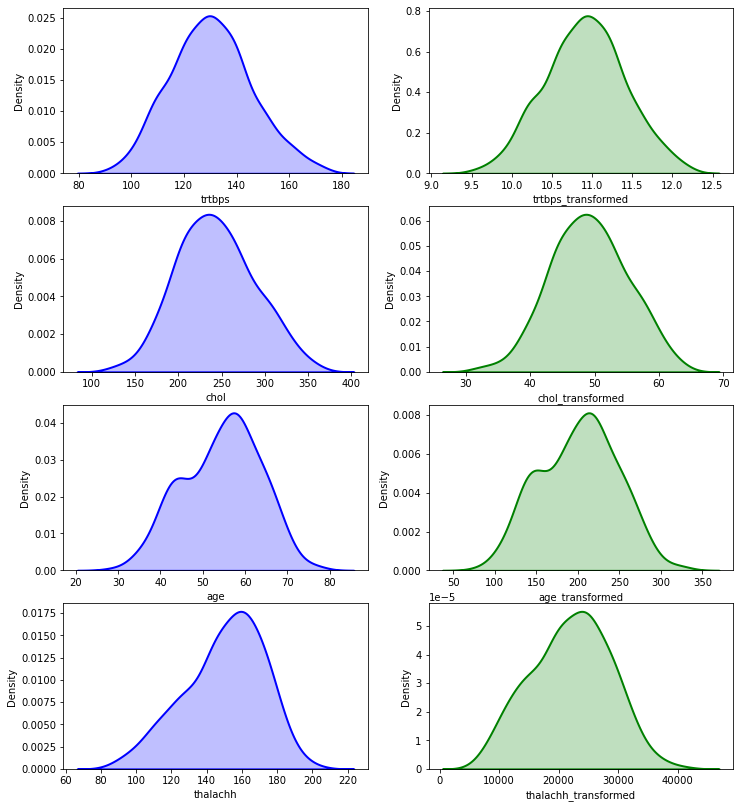

In [874]:
import matplotlib.pyplot as plt
import seaborn as sns

extended_features = []

fig, ax = plt.subplots(len(features), 2)

for idx, col in enumerate(features):
    transformed_col = f"{col}_transformed"

    sns.distplot(data[col], hist = False, kde = True,\
                    kde_kws = {'shade': True, 'linewidth': 2}, \
                    label = "Original data", color ="blue", ax = ax[idx][0])
    sns.distplot(data[transformed_col], hist = False, kde = True, \
                    kde_kws = {'shade': True, 'linewidth': 2},\
                    label = "Transformed data", color ="green", ax = ax[idx][1])

    extended_features.append(col)
    extended_features.append(transformed_col)

# rescaling the subplots
fig.set_figheight(14)
fig.set_figwidth(12)

A pesar de que el test de shapiro nos está dando valores muy bajos de p-value, observando las distribuciones se aprecia una tendencia muy similar a la normal. Si bien es cierto que las 4 variables tienen un pequeño pico (especialmente significativo para la edad) alrededor del primer tercio del eje X.

Habiendo visto en estos gráficos que la distribución no es totalmente desordenada y su cercanía a una normal, vamos a realizar un segundo test (Kolmogorov-Smirnov) y en función de sus resultados proseguiremos con los análisis asumiendo o no la normalidad de las variables.

In [875]:
from scipy.stats import kstest, norm

def ks_test_normality(data, col):
    loc, scale = norm.fit(data)
    n = norm(loc = loc, scale = scale)
    stat, pvalue = kstest(data, n.cdf)
    print(f"Result for {col}:")
    print("stat: %.9f, p: %.9f" % (stat, pvalue))
    if pvalue > 0.05:
        dist = "Gaussian"
    else:
        dist = "Non-gaussian"
    print(f"{dist} distribution\n")

In [876]:
print("### Testing with Kolmogorov-Smirnov  ###")

_ = [ks_test_normality(data[col], col) for col in extended_features if col.__contains__('_transformed')]   

### Testing with Kolmogorov-Smirnov  ###
Result for trtbps_transformed:
stat: 0.064328912, p: 0.155912023
Gaussian distribution

Result for chol_transformed:
stat: 0.028490910, p: 0.960597799
Gaussian distribution

Result for age_transformed:
stat: 0.064964444, p: 0.148276801
Gaussian distribution

Result for thalachh_transformed:
stat: 0.046677280, p: 0.508971731
Gaussian distribution



Obtenemos p-values suficientemente significativos para que, junto con los resultados de los gráficos, consideremos todas las variables transformadas normales excepto por la edad.

Si bien el p-value de K-S indica que sí que tiene una distribución Gaussiana, teniendo en cuenta el resultado de Shapiro-Wilk (que suele considerarse más robusto) y el gráfico anterior, resulta razonable no considerarla normal.

Además, esto nos permitirá poner en práctica técnicas no paramétricas para este tipo de variables. Por lo tanto, consideramos los siguientes tipos de variables:

In [877]:
normal_features = ["thalachh_transformed", "chol_transformed", "trtbps_transformed"]
abnormal_features = ["age"]

#### Homogeneidad de la varianza para distribuciones normales

Para distribuciones normales, se suele utilizar el test de Levene para determinar su homocedasticidad. Vamos a excluir la variable *age* de este análisis ya que como hemos indicado en el apartado anterior, no sigue una distribución normal.

In [878]:
from sklearn.preprocessing import StandardScaler

std_scaler = MinMaxScaler()

scaled_data = std_scaler.fit_transform(data[extended_features].to_numpy())
scaled_data = pd.DataFrame(scaled_data, columns=extended_features)

In [879]:
from scipy.stats import levene


def levene_test_homocedasticity(df: pd.DataFrame, extended_cols: list, mode: str = 'mean'):
    transformed_fields = [col for col in extended_cols if col.__contains__('_transformed')]
    for first_field in transformed_fields:
        transformed_fields.remove(first_field)
        for second_field in transformed_fields:
            stat, pvalue = levene(df[first_field], df[second_field], center=mode)
            print("stat: %.3f, p: %.3f" % (stat, pvalue))
            if pvalue > 0.05:
                dist = f"Homocedasticity between {first_field} and {second_field}"
            else:
                dist = f"Non-Homocedasticity between {first_field} and {second_field}"
            print(dist)

In [880]:
levene_test_homocedasticity(scaled_data, normal_features)

stat: 1.229, p: 0.268
Homocedasticity between thalachh_transformed and chol_transformed
stat: 0.194, p: 0.660
Homocedasticity between thalachh_transformed and trtbps_transformed
stat: 0.393, p: 0.531
Homocedasticity between trtbps_transformed and chol_transformed


#### Homogeneidad de la varianza para distribuciones no normales

Para medir la homocedasticidad de *age*, utilizaremos el test de Fligner-Killeen, que es la alternativa no-paramétrica del test de Levene

In [881]:
from scipy.stats import fligner

def fligner_test_homocedasticity(df: pd.DataFrame, extended_cols: list, mode: str = 'mean'):
    transformed_fields = [col for col in extended_cols if col.__contains__('_transformed')]
    for first_field in transformed_fields:
        transformed_fields.remove(first_field)
        for second_field in transformed_fields:
            stat, pvalue = fligner(df[first_field], df[second_field])
            print("stat: %.3f, p: %.3f" % (stat, pvalue))
            if pvalue > 0.05:
                dist = f"Homocedasticity between {first_field} and {second_field}"
            else:
                dist = f"Non-Homocedasticity between {first_field} and {second_field}"
            print(dist)

In [882]:
fligner_test_homocedasticity(scaled_data, extended_features)

stat: 0.350, p: 0.554
Homocedasticity between trtbps_transformed and chol_transformed
stat: 0.146, p: 0.703
Homocedasticity between trtbps_transformed and age_transformed
stat: 0.095, p: 0.758
Homocedasticity between trtbps_transformed and thalachh_transformed
stat: 0.313, p: 0.576
Homocedasticity between age_transformed and chol_transformed
stat: 0.477, p: 0.490
Homocedasticity between age_transformed and thalachh_transformed


El p-value es  mayor que 0.05 para todos los casos, por lo que obtenemos homogeneidad de la varianza de la edad respecto al resto de variables.

#### Resumen de variables y sus distribuciones:
- **age**: Tiene una distribución no normal pero presenta homogeneidad de la varianza respecto al resto de variables.
- **trtbps**: Tiene una distribución normal y presenta homogeneidad de la varianza respecto al resto de variables.
- **chol**: Tiene una distribución normal y presenta homogeneidad de la varianza respecto al resto de variables.
- **thallachh**: Tiene una distribución normal y presenta homogeneidad de la varianza respecto al resto de variables.

Con estos resultados obtenidos podemos dar paso a los análisis estadísticos.

### 4.3 Aplicación de pruebas estadísticas

En este apartado vamos a realizar varias pruebas estadísticas para entender de qué manera se relacionan y qué patrones existen en el conjunto de datos.

Vamos a comenzar calculando las matrices de correlación para las variables *feature*.

#### Matriz de correlación de Pearson para variables normales y homocedasticas

En el caso de las variables que presentan distribuciones normales, podemos usar el coeficiente de Pearson. Estas son todas, menos la edad.

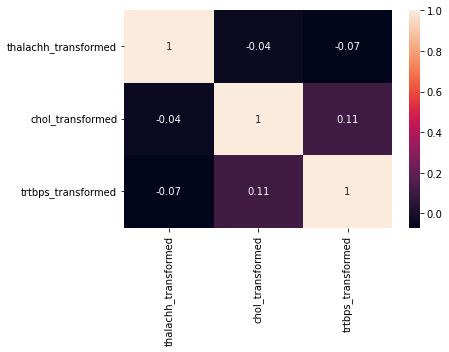

In [836]:
matrix = scaled_data[normal_features].corr(method='pearson').round(2)
sns.heatmap(matrix, annot=True)
plt.show()

#### Matriz de correlación de Spearman para variables no normales y homocedasticas

Para la edad, calculamos una nueva matriz de confusión, y esta vez aplicamos el método de Spearman, que es una alternativa al de Pearson no paramétrica que funciona también para variables que no siguen un distribución normal, que es el caso del campo *age*.

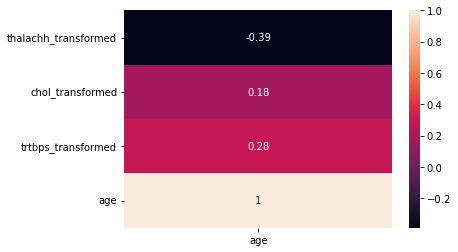

In [838]:
matrix = scaled_data[['thalachh_transformed', 'chol_transformed', 'trtbps_transformed', 'age']]\
            .corr(method='spearman').round(2)
sns.heatmap(matrix[abnormal_features], annot=True)
plt.show()

In [888]:
data.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,caa,...,desc_fbs,desc_sex,desc_restecg,desc_output,atipico_1,atipico_2,trtbps_transformed,chol_transformed,age_transformed,thalachh_transformed
0,63.0,1,3,145.0,233.0,1,0,150.0,0,0,...,Fasting Blood Sugar > 120 mg/dl,Man,Normal,High heart attack risk,False,False,11.393847,47.987363,245.026003,21447.532740
1,37.0,1,2,130.0,250.0,0,1,187.0,0,0,...,Fasting Blood Sugar < 120 mg/dl,Man,ST-T Wave abnormality,High heart attack risk,False,False,10.922868,50.242901,115.210734,34397.555059
2,41.0,0,1,130.0,204.0,0,0,172.0,0,0,...,Fasting Blood Sugar < 120 mg/dl,Woman,Normal,High heart attack risk,False,False,10.922868,43.994208,133.288287,28755.762178
3,56.0,1,1,120.0,236.0,0,1,178.0,0,0,...,Fasting Blood Sugar < 120 mg/dl,Man,ST-T Wave abnormality,High heart attack risk,False,False,10.587214,48.389693,207.381618,30947.871299
4,57.0,0,0,120.0,354.0,0,1,163.0,1,0,...,Fasting Blood Sugar < 120 mg/dl,Woman,ST-T Wave abnormality,High heart attack risk,True,False,10.587214,62.982016,212.646759,25628.069210


## 5. Representación de los resultados

Se realiza durante toda la práctica.

## 6. Resolución del problema

## Vídeo

[Link al vídeo](www.google.es)